In [1]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root 
change_wd_to_project_root()
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from src.utils.notebook_imports import *
InteractiveShell.ast_node_interactivity = "last"
Console_and_file_logger('close_gap', logging.INFO)


search for root_dir and set working directory
Working directory set to: /mnt/data/git/cardio


2020-01-19 12:39:55,631 INFO -------------------- Start --------------------
2020-01-19 12:39:55,631 INFO Working directory: /mnt/data/git/cardio.
2020-01-19 12:39:55,632 INFO Log file: ./logs/close_gap.log


# Close the generalization gap, by adding GCN-patients

# Train a new model from scratch

In [2]:
# trained from scratch plus n x GCN 
evaluations = sorted(glob.glob('reports/evaluation/2D/acdc/finetune_new/**/evaluation_score.csv'))
evaluations

['reports/evaluation/2D/acdc/finetune_new/plus0/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new/plus10/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new/plus100/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new/plus125/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new/plus150/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new/plus2/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new/plus20/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new/plus30/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new/plus40/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new/plus5/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new/plus50/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new/plus75/evaluation_score.csv']

In [3]:
# load all dataframes, and concat them
dfs = [pd.read_csv(f).set_index('Evaluation') for f in evaluations]
df_comb = pd.concat(dfs)
df_comb = df_comb.reset_index().drop_duplicates(subset='Evaluation',keep='first').set_index('Evaluation') # drop duplicate rows by evaluation index
df_comb.head()

,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/acdc/finetune_new/plus0_acdc_all_0_test,-0.822073,0.921780,0.858641,0.892852,0.953358,0.918775
2D/acdc/finetune_new/plus0_acdc_all_0_train,-0.826550,0.942773,0.859174,0.913377,0.963829,0.950672
2D/acdc/finetune_new/plus0_gcn_all_0_all,-0.789324,0.800060,0.848050,0.742377,0.884809,0.775698
2D/acdc/finetune_new/plus10_acdc_all_0_test,-0.758306,0.919200,0.828823,0.891553,0.954482,0.911581
2D/acdc/finetune_new/plus10_acdc_all_0_train,-0.764385,0.933241,0.830477,0.905449,0.945829,0.949158


In [4]:
# minor cleaning for the evaluation files trained from scratch
df_comb.index = df_comb.index.str.replace('tetrat', 'tetra_t')
df_comb.index = df_comb.index.str.replace('tetraa', 'tetra_a')
df_comb.index = df_comb.index.str.replace('acdca', 'acdc_a')
df_comb.index = df_comb.index.str.replace('acdct', 'acdc_t')
df_comb.index = df_comb.index.str.replace('plus5_', 'plus05_')
df_comb['trained'] = [e[0].split('/')[1] for e in df_comb.index.str.split('_')]
df_comb['fold'] = [e[-2] for e in df_comb.index.str.split('_')]
df_comb['gcn data'] = [re.findall(r"plus(\d+)",e)[0] for e in df_comb.index]
df_comb['gcn data'] = df_comb['gcn data'].astype(np.int16)
df_comb['evaluate'] = ['{}_{}'.format(e[-4],e[-1]) for e in df_comb.index.str.split('_')] # select the buckets from the end, to ignore folders with underscore
df_comb = df_comb.sort_index()
df_comb = df_comb.drop(['loss', 'dice_coef_background'], axis=1, errors='ignore')

# capital evaluation paths
df_comb['evaluate'] = df_comb['evaluate'].str.replace('gcn_', 'GCN ')
df_comb['evaluate'] = df_comb['evaluate'].str.replace('tetra_', 'GCN ')
df_comb['evaluate'] = df_comb['evaluate'].str.replace('acdc_', 'ACDC ')

df_comb['trained'] = df_comb['trained'].str.replace('gcn', 'GCN')
df_comb['trained'] = df_comb['trained'].str.replace('tetra', 'GCN')
df_comb['trained'] = df_comb['trained'].str.replace('acdc', 'ACDC')

# custom ordering for the evaluation paths
df_comb['evaluate'] = pd.Categorical(df_comb['evaluate'], ['ACDC train', 'ACDC test', 'GCN all'])
df_comb = df_comb.sort_index()
df_comb = df_comb.sort_values(by='gcn data')
df_comb.head()

,dice_coef_labels,dice_coef_myo,dice_coef_lv,dice_coef_rv,trained,fold,gcn data,evaluate
Evaluation,,,,,,,,
2D/acdc/finetune_new/plus0_acdc_all_0_test,0.921780,0.892852,0.953358,0.918775,ACDC,0,0,ACDC test
2D/acdc/finetune_new/plus0_acdc_all_0_train,0.942773,0.913377,0.963829,0.950672,ACDC,0,0,ACDC train
2D/acdc/finetune_new/plus0_gcn_all_0_all,0.800060,0.742377,0.884809,0.775698,ACDC,0,0,GCN all
2D/acdc/finetune_new/plus2_acdc_all_0_train,0.939889,0.909000,0.963258,0.948414,ACDC,0,2,ACDC train
2D/acdc/finetune_new/plus2_acdc_all_0_test,0.921205,0.892958,0.954571,0.916278,ACDC,0,2,ACDC test


In [5]:
df_long = pd.melt(df_comb, ['gcn data', 'evaluate'], ['dice_coef_labels', 'dice_coef_lv', 'dice_coef_myo', 'dice_coef_rv'])
df_long.head()

,gcn data,evaluate,variable,value
0,0,ACDC test,dice_coef_labels,0.921780
1,0,ACDC train,dice_coef_labels,0.942773
2,0,GCN all,dice_coef_labels,0.800060
3,2,ACDC train,dice_coef_labels,0.939889
4,2,ACDC test,dice_coef_labels,0.921205


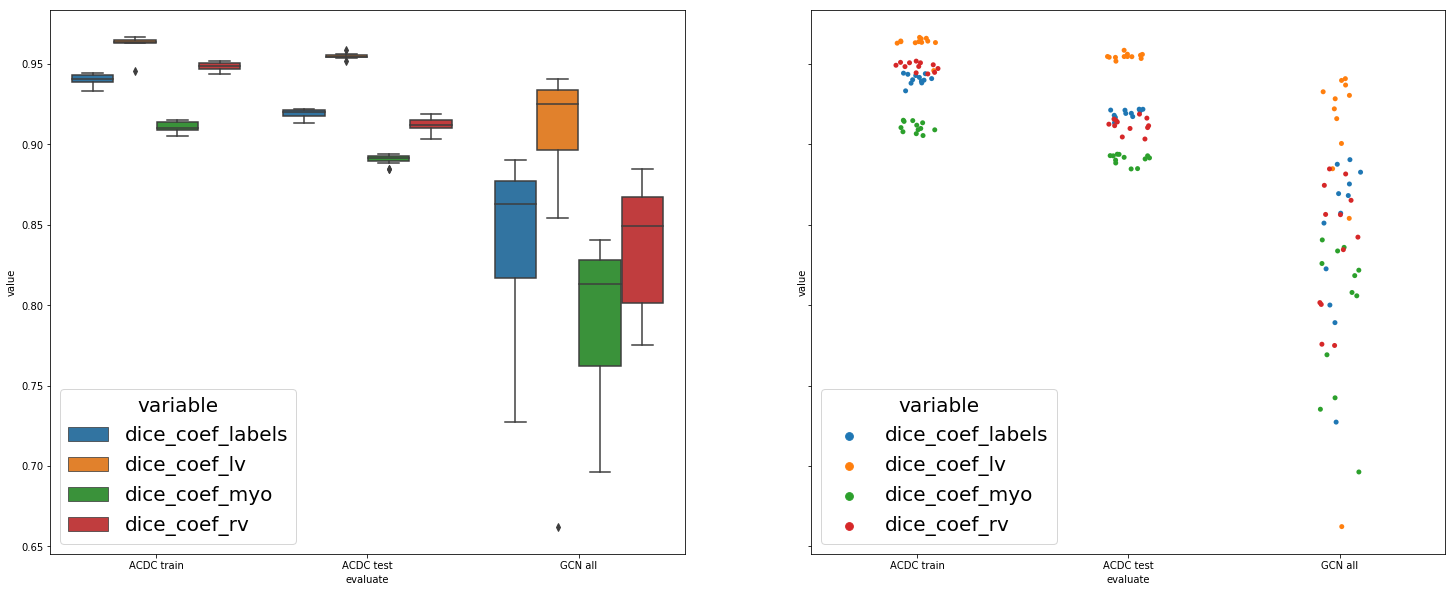

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10), sharey=True)
plt.rcParams.update({'font.size': 20})
ax1 = sns.boxplot(x='evaluate', hue='variable', y='value', data=df_long, ax=ax1)

ax2 = sns.stripplot(x='evaluate', hue='variable', y='value', data=df_long,  ax=ax2)

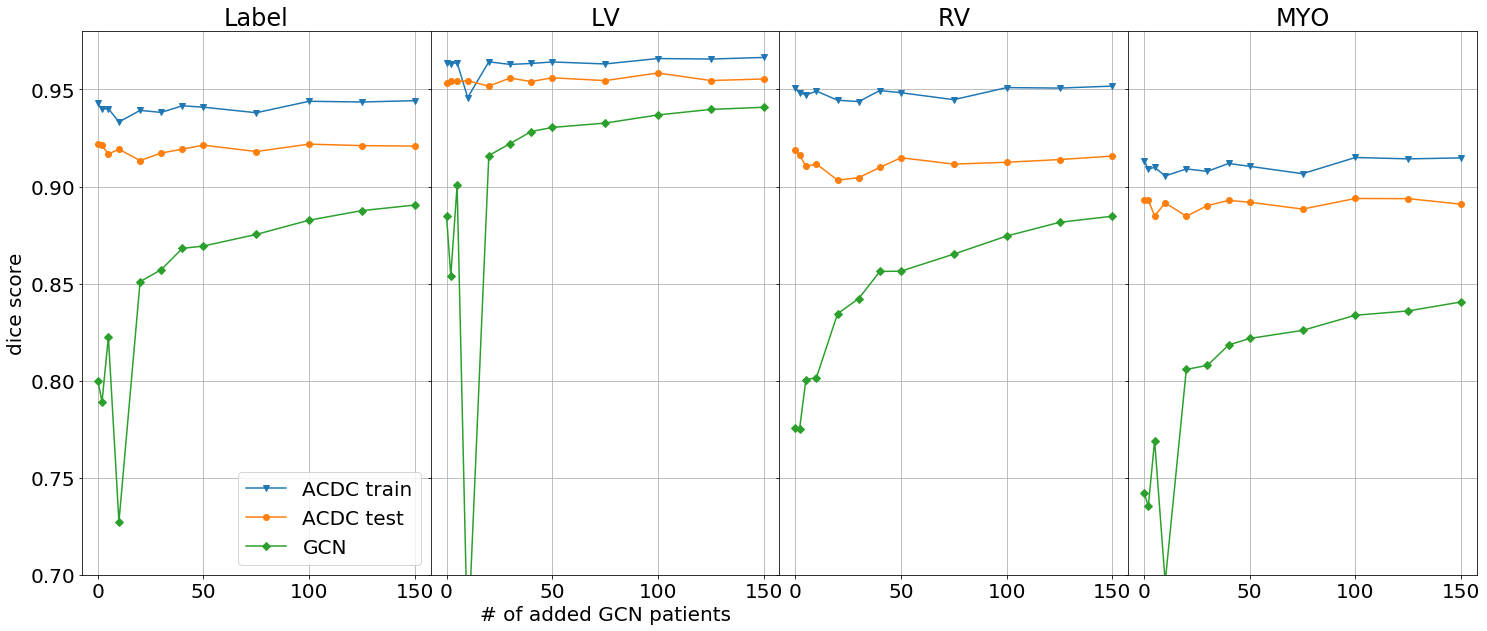

In [7]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,10), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)
y_top = 0.98
y_bottom = 0.70
# label
df_lv_train = df_long[(df_long['variable'] == 'dice_coef_labels') & (df_long['evaluate'] == 'ACDC train')]
ax1.plot(df_lv_train['gcn data'], df_lv_train['value'], marker='v', label='ACDC train')
df_lv_test = df_long[(df_long['variable'] == 'dice_coef_labels') & (df_long['evaluate'] == 'ACDC test')]
ax1.plot(df_lv_test['gcn data'], df_lv_test['value'], marker='o', label='ACDC test')
df_lv_gcn = df_long[(df_long['variable'] == 'dice_coef_labels') & (df_long['evaluate'] == 'GCN all')]
ax1.plot(df_lv_gcn['gcn data'], df_lv_gcn['value'], marker='D', label='GCN')
ax1.set_title('Label')
ax1.grid()
ax1.legend(loc='lower right')
ax1.set_ylim(top=y_top, bottom=y_bottom)

# LV
df_lv_train = df_long[(df_long['variable'] == 'dice_coef_lv') & (df_long['evaluate'] == 'ACDC train')]
ax2.plot(df_lv_train['gcn data'], df_lv_train['value'], marker='v')
df_lv_test = df_long[(df_long['variable'] == 'dice_coef_lv') & (df_long['evaluate'] == 'ACDC test')]
ax2.plot(df_lv_test['gcn data'], df_lv_test['value'], marker='o')
df_lv_gcn = df_long[(df_long['variable'] == 'dice_coef_lv') & (df_long['evaluate'] == 'GCN all')]
ax2.plot(df_lv_gcn['gcn data'], df_lv_gcn['value'], marker='D')
ax2.set_title('LV')
ax2.grid()
ax2.set_ylim(top=y_top, bottom=y_bottom)

# RV
df_lv_train = df_long[(df_long['variable'] == 'dice_coef_rv') & (df_long['evaluate'] == 'ACDC train')]
ax3.plot(df_lv_train['gcn data'], df_lv_train['value'], marker='v')
df_lv_test = df_long[(df_long['variable'] == 'dice_coef_rv') & (df_long['evaluate'] == 'ACDC test')]
ax3.plot(df_lv_test['gcn data'], df_lv_test['value'], marker='o')
df_lv_gcn = df_long[(df_long['variable'] == 'dice_coef_rv') & (df_long['evaluate'] == 'GCN all')]
ax3.plot(df_lv_gcn['gcn data'], df_lv_gcn['value'], marker='D')
ax3.set_title('RV')
ax3.grid()
ax3.set_ylim(top=y_top, bottom=y_bottom)

# Myo
df_lv_train = df_long[(df_long['variable'] == 'dice_coef_myo') & (df_long['evaluate'] == 'ACDC train')]
ax4.plot(df_lv_train['gcn data'], df_lv_train['value'], marker='v')
df_lv_test = df_long[(df_long['variable'] == 'dice_coef_myo') & (df_long['evaluate'] == 'ACDC test')]
ax4.plot(df_lv_test['gcn data'], df_lv_test['value'], marker='o')
df_lv_gcn = df_long[(df_long['variable'] == 'dice_coef_myo') & (df_long['evaluate'] == 'GCN all')]
ax4.plot(df_lv_gcn['gcn data'], df_lv_gcn['value'], marker='D')
ax4.set_title('MYO')
ax4.grid()
ax4.set_ylim(top=y_top, bottom=y_bottom)
ax2.set_xlabel('# of added GCN patients')
ax1.set_ylabel('dice score')
plt.savefig('reports/evaluation/2D/new_kfold/close_gap_by_trainnew.pdf')

plt.show()



#  Finetune the baseline model

In [8]:
# Finetuned on baseline plus n x GCN
# finetune_new --> trained from scratch
# finetune_new2 --> finetuned on ACDC & GCN
# finetune_new3 --> finetuned on GCN data
evaluations = sorted(glob.glob('reports/evaluation/2D/acdc/finetune_new2/**/evaluation_score.csv'))
evaluations

['reports/evaluation/2D/acdc/finetune_new2/plus0/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new2/plus10/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new2/plus100/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new2/plus125/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new2/plus150/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new2/plus20/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new2/plus30/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new2/plus5/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new2/plus50/evaluation_score.csv',
 'reports/evaluation/2D/acdc/finetune_new2/plus75/evaluation_score.csv']

In [9]:
# load all dataframes, and concat them
dfs = [pd.read_csv(f).set_index('Evaluation') for f in evaluations]
df_comb = pd.concat(dfs)
df_comb = df_comb.reset_index().drop_duplicates(subset='Evaluation',keep='first').set_index('Evaluation') # drop duplicate rows by evaluation index
df_comb.head()

,loss,dice_coef_labels,dice_coef_background,dice_coef_myo,dice_coef_lv,dice_coef_rv
Evaluation,,,,,,
2D/acdc/finetune_new2/plus0_acdc_all_0_test,-0.820571,0.919136,0.857988,0.888019,0.952060,0.916664
2D/acdc/finetune_new2/plus0_acdc_all_0_train,-0.827086,0.941960,0.859737,0.912454,0.963255,0.950136
2D/acdc/finetune_new2/plus0_gcn_all_0_all,-0.788947,0.793239,0.848579,0.732740,0.877436,0.770825
2D/acdc/finetune_new2/plus10_acdc_all_0_test,-0.841267,0.925744,0.874337,0.896473,0.958593,0.921496
2D/acdc/finetune_new2/plus10_acdc_all_0_train,-0.847069,0.945246,0.876299,0.916012,0.966449,0.953296


In [10]:
# minor cleaning for the evaluation files trained from scratch
df_comb.index = df_comb.index.str.replace('tetrat', 'tetra_t')
df_comb.index = df_comb.index.str.replace('tetraa', 'tetra_a')
df_comb.index = df_comb.index.str.replace('acdca', 'acdc_a')
df_comb.index = df_comb.index.str.replace('acdct', 'acdc_t')
df_comb.index = df_comb.index.str.replace('plus5_', 'plus05_')
df_comb['trained'] = [e[0].split('/')[1] for e in df_comb.index.str.split('_')]
df_comb['fold'] = [e[-2] for e in df_comb.index.str.split('_')]
df_comb['gcn data'] = [re.findall(r"plus(\d+)",e)[0] for e in df_comb.index]
df_comb['gcn data'] = df_comb['gcn data'].astype(np.int16)
df_comb['evaluate'] = ['{}_{}'.format(e[-4],e[-1]) for e in df_comb.index.str.split('_')] # select the buckets from the end, to ignore folders with underscore
df_comb = df_comb.sort_index()
df_comb = df_comb.drop(['loss', 'dice_coef_background'], axis=1, errors='ignore')

# capital evaluation paths
df_comb['evaluate'] = df_comb['evaluate'].str.replace('gcn_', 'GCN ')
df_comb['evaluate'] = df_comb['evaluate'].str.replace('tetra_', 'GCN ')
df_comb['evaluate'] = df_comb['evaluate'].str.replace('acdc_', 'ACDC ')

df_comb['trained'] = df_comb['trained'].str.replace('gcn', 'GCN')
df_comb['trained'] = df_comb['trained'].str.replace('tetra', 'GCN')
df_comb['trained'] = df_comb['trained'].str.replace('acdc', 'ACDC')

# custom ordering for the evaluation paths
df_comb['evaluate'] = pd.Categorical(df_comb['evaluate'], ['ACDC train', 'ACDC test', 'GCN all'])
df_comb = df_comb.sort_index()
df_comb = df_comb.sort_values(by='gcn data')
df_comb.head()

,dice_coef_labels,dice_coef_myo,dice_coef_lv,dice_coef_rv,trained,fold,gcn data,evaluate
Evaluation,,,,,,,,
2D/acdc/finetune_new2/plus0_acdc_all_0_test,0.919136,0.888019,0.952060,0.916664,ACDC,0,0,ACDC test
2D/acdc/finetune_new2/plus0_acdc_all_0_train,0.941960,0.912454,0.963255,0.950136,ACDC,0,0,ACDC train
2D/acdc/finetune_new2/plus0_gcn_all_0_all,0.793239,0.732740,0.877436,0.770825,ACDC,0,0,GCN all
2D/acdc/finetune_new2/plus05_acdc_all_0_test,0.924229,0.896759,0.955773,0.919292,ACDC,0,5,ACDC test
2D/acdc/finetune_new2/plus05_acdc_all_0_train,0.945129,0.914099,0.966644,0.954936,ACDC,0,5,ACDC train


# Combine multiple evaluations

In [11]:
df_long = pd.melt(df_comb, ['gcn data', 'evaluate'], ['dice_coef_labels', 'dice_coef_lv', 'dice_coef_myo', 'dice_coef_rv'])
df_long.head()

,gcn data,evaluate,variable,value
0,0,ACDC test,dice_coef_labels,0.919136
1,0,ACDC train,dice_coef_labels,0.941960
2,0,GCN all,dice_coef_labels,0.793239
3,5,ACDC test,dice_coef_labels,0.924229
4,5,ACDC train,dice_coef_labels,0.945129


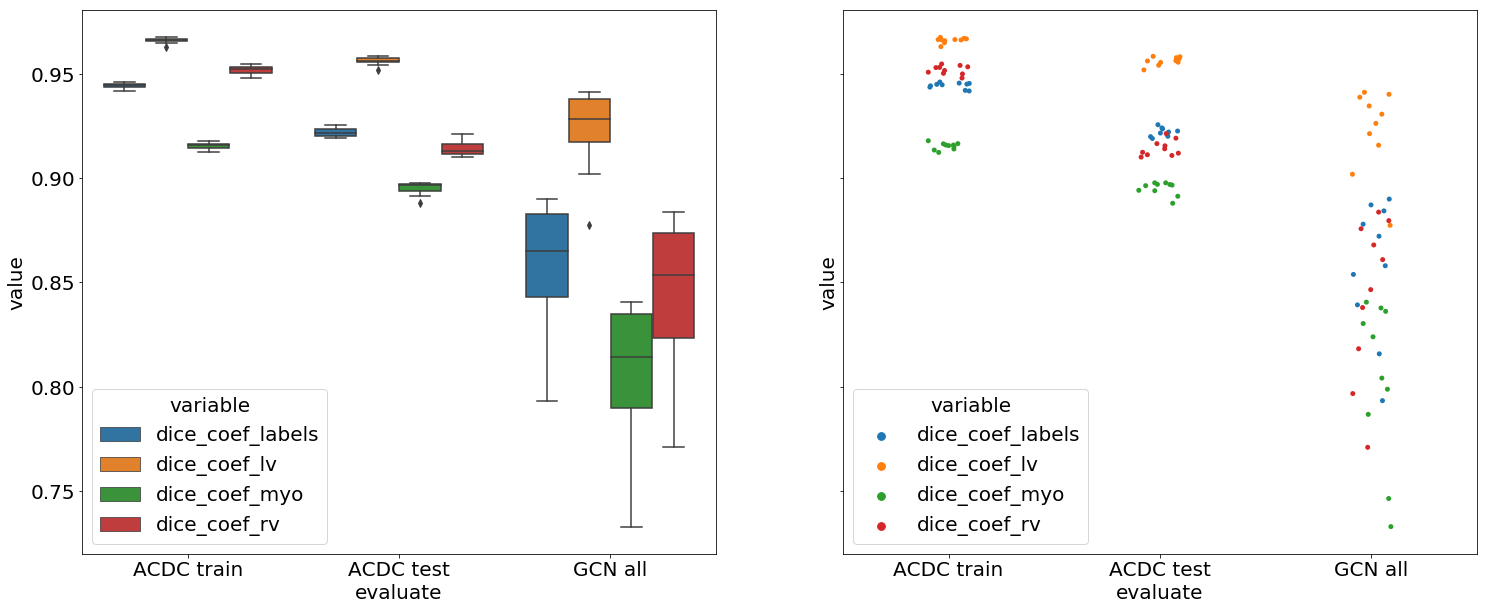

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,10), sharey=True)
plt.rcParams.update({'font.size': 20})
ax1 = sns.boxplot(x='evaluate', hue='variable', y='value', data=df_long, ax=ax1)

ax2 = sns.stripplot(x='evaluate', hue='variable', y='value', data=df_long,  ax=ax2)

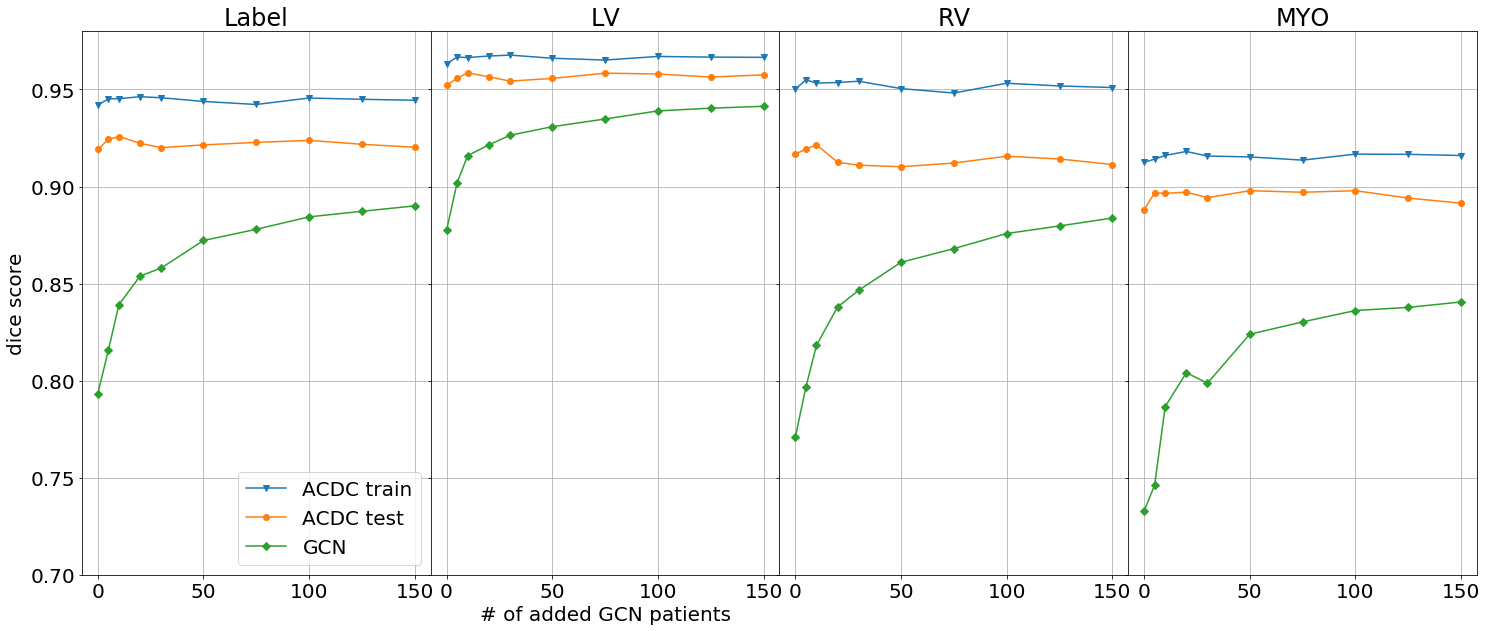

In [13]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25,10), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)
y_top = 0.98
y_bottom = 0.70
# label
df_lv_train = df_long[(df_long['variable'] == 'dice_coef_labels') & (df_long['evaluate'] == 'ACDC train')]
ax1.plot(df_lv_train['gcn data'], df_lv_train['value'], marker='v', label='ACDC train')
df_lv_test = df_long[(df_long['variable'] == 'dice_coef_labels') & (df_long['evaluate'] == 'ACDC test')]
ax1.plot(df_lv_test['gcn data'], df_lv_test['value'], marker='o', label='ACDC test')
df_lv_gcn = df_long[(df_long['variable'] == 'dice_coef_labels') & (df_long['evaluate'] == 'GCN all')]
ax1.plot(df_lv_gcn['gcn data'], df_lv_gcn['value'], marker='D', label='GCN')
ax1.set_title('Label')
ax1.grid()
ax1.legend(loc='lower right')
ax1.set_ylim(top=y_top, bottom=y_bottom)

# LV
df_lv_train = df_long[(df_long['variable'] == 'dice_coef_lv') & (df_long['evaluate'] == 'ACDC train')]
ax2.plot(df_lv_train['gcn data'], df_lv_train['value'], marker='v')
df_lv_test = df_long[(df_long['variable'] == 'dice_coef_lv') & (df_long['evaluate'] == 'ACDC test')]
ax2.plot(df_lv_test['gcn data'], df_lv_test['value'], marker='o')
df_lv_gcn = df_long[(df_long['variable'] == 'dice_coef_lv') & (df_long['evaluate'] == 'GCN all')]
ax2.plot(df_lv_gcn['gcn data'], df_lv_gcn['value'], marker='D')
ax2.set_title('LV')
ax2.grid()
ax2.set_ylim(top=y_top, bottom=y_bottom)

# RVß
df_lv_train = df_long[(df_long['variable'] == 'dice_coef_rv') & (df_long['evaluate'] == 'ACDC train')]
ax3.plot(df_lv_train['gcn data'], df_lv_train['value'], marker='v')
df_lv_test = df_long[(df_long['variable'] == 'dice_coef_rv') & (df_long['evaluate'] == 'ACDC test')]
ax3.plot(df_lv_test['gcn data'], df_lv_test['value'], marker='o')
df_lv_gcn = df_long[(df_long['variable'] == 'dice_coef_rv') & (df_long['evaluate'] == 'GCN all')]
ax3.plot(df_lv_gcn['gcn data'], df_lv_gcn['value'], marker='D')
ax3.set_title('RV')
ax3.grid()
ax3.set_ylim(top=y_top, bottom=y_bottom)

# Myo
df_lv_train = df_long[(df_long['variable'] == 'dice_coef_myo') & (df_long['evaluate'] == 'ACDC train')]
ax4.plot(df_lv_train['gcn data'], df_lv_train['value'], marker='v')
df_lv_test = df_long[(df_long['variable'] == 'dice_coef_myo') & (df_long['evaluate'] == 'ACDC test')]
ax4.plot(df_lv_test['gcn data'], df_lv_test['value'], marker='o')
df_lv_gcn = df_long[(df_long['variable'] == 'dice_coef_myo') & (df_long['evaluate'] == 'GCN all')]
ax4.plot(df_lv_gcn['gcn data'], df_lv_gcn['value'], marker='D')
ax4.set_title('MYO')
ax4.grid()
ax4.set_ylim(top=y_top, bottom=y_bottom)
ax2.set_xlabel('# of added GCN patients')
ax1.set_ylabel('dice score')
plt.savefig('reports/evaluation/2D/new_kfold/close_gap_by_finetune.pdf')

plt.show()

# Dice improvements per dataset and label by extending the trainings-dataset with GCN data

In [14]:
def pop_std(x):
    """Helper to get the population SD, pandas returns a different SD as numpy by default"""
    return x.std(ddof=0)

# group by training and evaluation datasets --> 4 rows/folds per grouping
# aggregate over each of this 4 folds and calculate the mean and SD
# agg expects a dict with columnname: [list of functions which should be applied]
result = df_comb.groupby(['trained', 'evaluate'], as_index=False).agg({'dice_coef_labels':['mean',pop_std], 'dice_coef_lv':['mean',pop_std], 'dice_coef_myo':['mean',pop_std], 'dice_coef_rv':['mean',pop_std]})
result

trained    evaluate dice_coef_labels           dice_coef_lv            \
                                  mean   pop_std         mean   pop_std   
0    ACDC  ACDC train         0.944532  0.001374     0.966265  0.001193   
1    ACDC   ACDC test         0.922127  0.001955     0.956315  0.001910   
2    ACDC     GCN all         0.857188  0.030858     0.922936  0.019166   

  dice_coef_myo           dice_coef_rv            
           mean   pop_std         mean   pop_std  
0      0.915438  0.001566     0.952072  0.002020  
1      0.895081  0.003053     0.914437  0.003586  
2      0.803697  0.036517     0.843830  0.036111

In [15]:
# get the gaps for GCN = 0 and GCN = 150
# how much does each label increase by finetuning
# percentage increate per patient

In [17]:
df_long[df_long['evaluate'] == 'ACDC test'].head()

,gcn data,evaluate,variable,value
0,0,ACDC test,dice_coef_labels,0.919136
3,5,ACDC test,dice_coef_labels,0.924229
8,10,ACDC test,dice_coef_labels,0.925744
11,20,ACDC test,dice_coef_labels,0.922245
14,30,ACDC test,dice_coef_labels,0.920023


In [18]:
df_long['gcn data'].unique()

array([  0,   5,  10,  20,  30,  50,  75, 100, 125, 150])

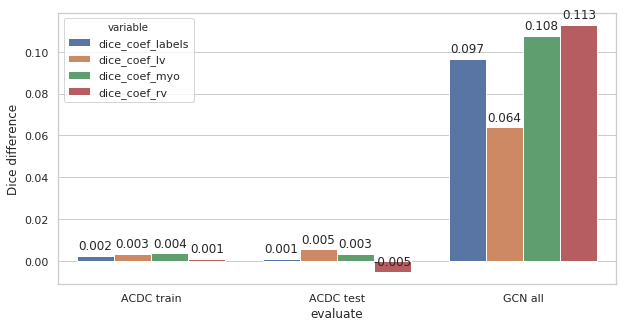

In [20]:

fig, ax = plt.subplots(figsize=(10,5))
sns.set(style="whitegrid", context='notebook', font_scale=1)

df_gap = df_long[df_long['gcn data'] == 0].sort_values(by=(['evaluate', 'variable']))
df_gap['value 150'] = df_long[df_long['gcn data'] == 150].sort_values(by=(['evaluate', 'variable']))['value'].values
df_gap['increase total'] = df_gap['value 150'] - df_gap['value']
g = sns.barplot(x='evaluate', y='increase total', hue='variable', data=df_gap, )
groupedvalues=df_gap.groupby('variable').sum().reset_index()
# Put the legend out of the figure
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

for p in g.patches:
    g.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.set_ylabel('Dice difference')
#ax.set_title('Dice score increase \nper label and dataset \nby adding 150 GCN patients')
#plt.tight_layout()
plt.savefig('reports/close_gap_increase.pdf')

In [82]:
df_gap

,variable,evaluate,value_0,value_150,increase total
0,dice_coef_labels,ACDC test,0.919136,0.944428,0.025292
1,dice_coef_labels,ACDC train,0.941960,0.920211,-0.021750
2,dice_coef_labels,GCN all,0.793239,0.890039,0.096800
3,dice_coef_lv,ACDC test,0.952060,0.966538,0.014478
4,dice_coef_lv,ACDC train,0.963255,0.957523,-0.005731
5,dice_coef_lv,GCN all,0.877436,0.941322,0.063886
6,dice_coef_myo,ACDC test,0.888019,0.915974,0.027955
7,dice_coef_myo,ACDC train,0.912454,0.891400,-0.021054
8,dice_coef_myo,GCN all,0.732740,0.840533,0.107793
9,dice_coef_rv,ACDC test,0.916664,0.950985,0.034321


In [45]:
pd.concat([df_long[df_long['gcn data'] == 150], df_long[df_long['gcn data'] == 0]])

,gcn data,evaluate,variable,value
27,150,ACDC train,dice_coef_labels,0.944428
28,150,ACDC test,dice_coef_labels,0.920211
29,150,GCN all,dice_coef_labels,0.890039
57,150,ACDC train,dice_coef_lv,0.966538
58,150,ACDC test,dice_coef_lv,0.957523


In [17]:
def pop_std(x):
    """Helper to get the population SD, pandas returns a different SD as numpy by default"""
    return x.std(ddof=0)

# group by training and evaluation datasets --> 4 rows/folds per grouping
# aggregate over each of this 4 folds and calculate the mean and SD
# agg expects a dict with columnname: [list of functions which should be applied]
result = df_comb.groupby(['trained', 'evaluate'], as_index=False).agg({'dice_coef_labels':['min',pop_std],  'dice_coef_lv':['max',pop_std], 'dice_coef_myo':['mean',pop_std], 'dice_coef_rv':['mean',pop_std]})
result

SyntaxError: invalid syntax (<ipython-input-17-6053b4bce53c>, line 8)